In [121]:
import numpy as np
import pandas as pd 
from typing import Any
import seaborn as sns
import matplotlib.pyplot as plt

## Data Source: https://www.hockey-reference.com/leagues/NHL_2022.html ##

## Dataset

In [122]:
df = pd.DataFrame(pd.read_csv('../data/team_stats.csv', index_col=[0]))
df.head()

Team  AvAge  GP   W   L  OL  PTS   PTS%   GF   GA  ...  \
Rk                                                                    ...   
1      Florida Panthers   27.8  82  58  18   6  122  0.744  337  242  ...   
2    Colorado Avalanche   28.2  82  56  19   7  119  0.726  308  232  ...   
3   Carolina Hurricanes   28.3  82  54  20   8  116  0.707  277  200  ...   
4   Toronto Maple Leafs   28.4  82  54  21   7  115  0.701  312  252  ...   
5        Minnesota Wild   29.4  82  53  22   7  113  0.689  305  249  ...   

      PK%  SH  SHA  PIM/G  oPIM/G     S    S%    SA    SV%  SO  
Rk                                                              
1   79.54  12    8   10.1    10.8  3062  11.0  2515  0.904   5  
2   79.66   6    5    9.0    10.4  2874  10.7  2625  0.912   7  
3   88.04   4    3    9.2     7.7  2798   9.9  2310  0.913   6  
4   82.05  13    4    8.6     8.5  2835  11.0  2511  0.900   7  
5   76.14   2    5   10.8    10.8  2666  11.4  2577  0.903   3  

[5 rows x 31 columns]

## EDA

Looking into the data, some key metrics indicating win-potential in a biased assumption are:
- Goal Differential (goals for versus against a team)
- Points Percentage (PTS%)
- Win/Loss ratio
- Overtime Losses (OL)
- Shootout W/L Ratio
- Penalty Killing Percentage (PK%)
- Power Play Performance Ratio: Power Play Goals (PP) versus Power Play Goals Against (PPA)
- Save Percentage (SV%), or save efficiency
- Shooting Percentage (S%), or accuracy

Few of these exist within the data and some will need to be extracted as features. 

### Correlations

Plotting correlations in the data, I'm looking at any at least 90% strong and less than a 100% correlation to focus on variables of interest. 

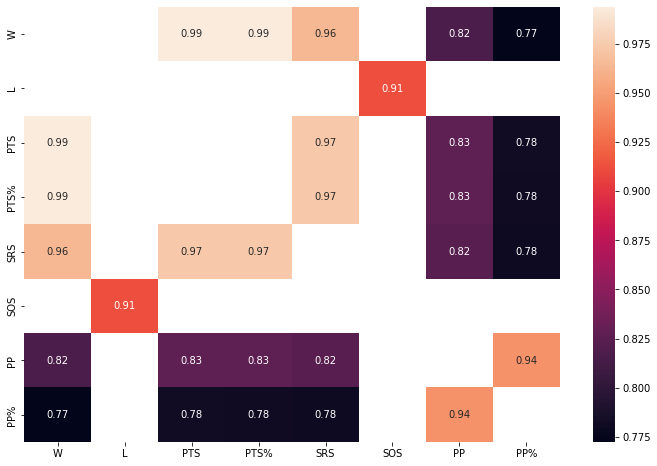

W         L       PTS      PTS%       SRS       SOS        PP  \
0  0.993766  0.912203  0.993766  0.993735  0.973541  0.912203  0.944115   

        PP%  
0  0.944115

In [124]:
## Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## Determining strongest correlation patterns
strong_corrs_df = pd.DataFrame({k:v for k, v in corr[~corr.isna()].max().dropna().items()}, index=[0])

plt.figure(figsize=(12,8))

# corr = df.corr() - all correlations
corr = df[['W', 'L', 'PTS', 'PTS%', 'SRS', 'SOS', 'PP', 'PP%']].corr()

corr = corr[np.logical_and(corr>0.70, corr<.9999)].abs()

sns.heatmap(corr, annot=True)

plt.show()

strong_corrs_df

### Summary 

Looking at the strongest of correlations, we can tell that Wins, Losses, Points, Point Percentage, SRS, Strength of Schedule, Power Play, and Power Play Percentage are the most correlated variables. 

The strongest correlations are: 
- **Wins to Points & Point Percentage**
- **Points & Point Percentage to SRS** 
- **Wins to SRS**
- **Losses to Strength of Schedule (SOS)**
- **Power Play to Power Play Percentage (This is Obvious).**

## Feature Engineering
> Deterimining features based upon EDA

It appears that I'll need to focus on win, point, power play, and schedule statistics. Given I didn't see any correlation from goals for or against and wins, I'll need to create some features that summarize goals and can draw statistics from them we can measure based upon wins. These can be tied in as performance metrics, and if conducive, will reveal more insight into the top teams in the league. 

In [116]:
# Creating Column for Total Goals 
df['G'] = df.GF + df.GA 
# Creating Column for Total Power-Play Goals 
df['PPG'] = df.PP + df. PPA
# Creating Column for Total Games in Shootouts
df['SHOOTOUT'] = df.SOW + df. SOL

def ratio_maker(df: pd.DataFrame, newcol: str, xcol: str, ycol: str) -> Any: 
    df[f"{newcol}"] = (df[f"{xcol}"] / df[f"{ycol}"]).apply(lambda x: "{:.2%}".format(x)) 

## Calc new metrics and store in new cols 
ratio_maker(df, "WL%", "W", "GP") # win-loss percentage
ratio_maker(df, "GDIFF", "GF", "G") # goal differential
ratio_maker(df, "SOWL%", "SOW", "SHOOTOUT") # shootout win-loss ratio 
ratio_maker(df, "PPWL%", "PP", "PPG") # power-play success percentage

In [119]:
# Show New Metrics

wins = df[['Team','WL%', 'GDIFF', 'SOWL%', 'PPWL%']].sort_values('WL%', ascending=False).set_index('Team').head(10)
wins 

WL%   GDIFF   SOWL%   PPWL%
Team                                               
Florida Panthers     70.73%  58.20%  42.86%  54.70%
Colorado Avalanche   68.29%  57.04%  66.67%  58.26%
Carolina Hurricanes  65.85%  58.07%  33.33%  60.71%
Toronto Maple Leafs  65.85%  55.32%  75.00%  60.00%
Minnesota Wild       64.63%  55.05%  55.56%  45.69%
New York Rangers     63.41%  55.07%  57.14%  57.89%
Tampa Bay Lightning  62.20%  55.56%  28.57%  55.86%
Boston Bruins        62.20%  53.72%  50.00%  50.51%
Calgary Flames       60.98%  58.55%  50.00%  56.25%
St. Louis Blues      59.76%  56.39%  40.00%  65.00%

_Here, I created:_
- a win-loss percentage
- goal differential (to ensure the team can be seen having a positive or even record)
- win-loss percentage in games leading to shootout
- performance on the power play (percentage of power plays that were successful)